# Step 0: Preparations

Group 17: Jakob Svensson, Mahdi Afarideh, Maximilian Forsell

In [ ]:
!git clone https://github.com/MahdiTheGreat/Intro-to-language-modeling.git
%cd Intro-to-language-modeling

Cloning into 'Intro-to-language-modeling'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 70 (delta 37), reused 2 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 31.81 MiB | 22.86 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/Intro-to-language-modeling


In [ ]:
import sklearn
import nltk
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from tqdm import tqdm

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Set random seed for reproducibility
def set_seed(seed=2024):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(1998)

In [ ]:
# Helper function to plot the training metrics

def plot_training_metrics(train_acc, val_acc, train_loss, title, save_path):
    # Ensure that all input lists have the same length
    assert len(train_acc) == len(val_acc) == len(train_loss), "All input histories must have the same length."

    epochs = range(1, len(train_acc) + 1)

    # Create the metrics DataFrame
    df_metrics = pd.DataFrame({
        'Epoch': epochs,
        'Training Accuracy (%)': train_acc,
        'Validation Accuracy (%)': val_acc,
        'Training Loss': train_loss
    })

    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Training and Validation Accuracy on ax1
    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)', color=color)
    ax1.plot(df_metrics['Epoch'], df_metrics['Training Accuracy (%)'], label='Train Acc', color='tab:blue')
    ax1.plot(df_metrics['Epoch'], df_metrics['Validation Accuracy (%)'], label='Val Acc', color='tab:cyan')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for Training Loss
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Loss', color=color)
    ax2.plot(df_metrics['Epoch'], df_metrics['Training Loss'], label='Train Loss', color='tab:red')
    ax2.tick_params(axis='y', labelcolor=color)

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    # Set plot title and layout
    plt.title(title)
    plt.tight_layout()

    # Save and display the plot
    plt.savefig(save_path)
    plt.show()

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
print(f'Using device: {device}')

Using device: cuda


# Step 1 & 2

In [ ]:
dataset='lmdemo'
zip_file = f"{dataset}.zip"
!unzip -q $zip_file
!rm $zip_file

In [ ]:
training_set=open(f'{dataset}/train.txt','r',encoding='utf-8').read()
val_set=open(f'{dataset}/val.txt','r',encoding='utf-8').read()

In [ ]:
from collections import Counter
class VocabularyBuilder:
    def __init__(self, max_voc_size):
        self.max_voc_size = max_voc_size
        self.str_to_int = {}
        self.int_to_str = {}
        self.special_tokens = ["BEGINNING", "END", "UNKNOWN"]
        self.token_counter = Counter()

    def build_vocabulary(self, text):

        sents=nltk.word_tokenize(text.lower())

        for token in sents:
            self.token_counter[token] += 1

    def create_vocabulary(self):
        for idx, token in enumerate(self.special_tokens):
            self.str_to_int[token] = idx
            self.int_to_str[idx] = token

        max_words = self.max_voc_size - len(self.special_tokens)
        most_common_tokens = self.token_counter.most_common(max_words)

        for idx, (token, _) in enumerate(most_common_tokens, start=len(self.special_tokens)):
            self.str_to_int[token] = idx
            self.int_to_str[idx] = token

    def create_premade_vocabulary(self, c):
        for idx, token in enumerate(self.special_tokens):
            self.str_to_int[token] = idx
            self.int_to_str[idx] = token

        max_words = self.max_voc_size - len(self.special_tokens)
        most_common_tokens = c.most_common(max_words) # Here we can use a premade counter from a previous run

        for idx, (token, _) in enumerate(most_common_tokens, start=len(self.special_tokens)):
            self.str_to_int[token] = idx
            self.int_to_str[idx] = token

    def get_token_id(self, token):
        return self.str_to_int.get(token.lower(), self.str_to_int["UNKNOWN"])

    def get_token_str(self, token_id):
        return self.int_to_str.get(token_id, "UNKNOWN")

    def sanity_check(self): # Here we run the sanity tests recommended in the assignment
        assert len(self.str_to_int) <= self.max_voc_size, "Vocabulary size exceeds max_voc_size."

        for token in self.special_tokens:
            assert token in self.str_to_int, f"Missing special token: {token}"

        common_words = ["the", "and"]
        rare_words = ["cuboidal", "epiglottis"]

        for word in common_words:
            assert word in self.str_to_int, f"Common word '{word}' not in vocabulary."

        for word in rare_words:
            assert word not in self.str_to_int, f"Rare word '{word}' should not be in vocabulary."

        test_word = "the"
        token_id = self.get_token_id(test_word)
        assert self.get_token_str(token_id) == test_word.lower(), "Round-trip token mapping failed."

        print("Sanity check passed!")

vocab_builder = VocabularyBuilder(max_voc_size=20000)


In [ ]:
# Run only once!
for paragraph in tqdm(training_set.splitlines()):
  vocab_builder.build_vocabulary(paragraph)
vocab_builder.create_vocabulary()

100%|██████████| 294118/294118 [01:35<00:00, 3084.93it/s]


In [ ]:
# Save vocab so we don't have to rerun it
counter= vocab_builder.token_counter
with open("full_vocab", 'w') as f:
    for k,v in  counter.most_common():
        f.write( "{} {}\n".format(k,v) )

In [ ]:
# Run this using full_vocab from first run
premade_counter = Counter()

with open("/content/Intro-to-language-modeling/full_vocab", 'r') as file:
    for line in file:
        parts = line.split(" ")
        if len(parts) == 2:
            word, freq = parts[0], int(parts[1])
            premade_counter[word] = freq
vocab_builder.create_premade_vocabulary(premade_counter)


In [ ]:
# Perform sanity check
vocab_builder.sanity_check()

Sanity check passed!


In [ ]:
class TrainingDataPreparer:
    def __init__(self, vocab_builder, context_window_size):
        self.vocab_builder = vocab_builder
        self.N = context_window_size

    def encode_text(self, text):
        """Tokenizes and encodes a single string with special symbols.

        Parameters:
        - text (str): The input string to encode.

        Returns:
        - List[int]: A list of token IDs including BEGINNING and END tokens.
        """
        # Tokenize the text
        tokens = nltk.word_tokenize(text.lower())

        token_ids = [self.vocab_builder.get_token_id(token) for token in tokens]
        modified_tokens = [0]*self.N # Add N BEGINNING
        modified_tokens.extend(token_ids)
        modified_tokens.append(1) # Add 1 END

        return modified_tokens

    def create_training_sequences(self, text):
        """
        Creates training sequences from a single string by generating sequences of length N+1.

        Parameters:
        - text (str): The input string to create sequences from.

        Returns:
        - List[Tuple[List[int], int]]: A list of (context, target) pairs.
        """
        training_sequences = []

        encoded_text = self.encode_text(text)

        for i in range(len(encoded_text) - self.N):
            context = encoded_text[i : i + self.N]  # N tokens for context
            target = encoded_text[i + self.N]       # Next token as the target
            training_sequences.append((context, target))

        return training_sequences


In [ ]:
# Perform manual inspection
context_window_size = 3
data_preparer = TrainingDataPreparer(vocab_builder, context_window_size)

training_sequences = data_preparer.create_training_sequences(training_set[:100])

print("Training sequences:")
for context, target in training_sequences[:10]:  # Show the first few sequences
    print([vocab_builder.get_token_str(id) for id in context], "->", vocab_builder.get_token_str(target))

Training sequences:
['BEGINNING', 'BEGINNING', 'BEGINNING'] -> anatomy
['BEGINNING', 'BEGINNING', 'anatomy'] -> anatomy
['BEGINNING', 'anatomy', 'anatomy'] -> (
['anatomy', 'anatomy', '('] -> greek
['anatomy', '(', 'greek'] -> UNKNOWN
['(', 'greek', 'UNKNOWN'] -> ,
['greek', 'UNKNOWN', ','] -> “
['UNKNOWN', ',', '“'] -> dissection
[',', '“', 'dissection'] -> ”
['“', 'dissection', '”'] -> )


In [ ]:
## Creating a tensor dataset ##
from torch.utils.data import DataLoader, TensorDataset
def TorchDataLoader(training_sequences, batch_size):
  context_words = [item[0] for item in training_sequences]  # List of [context]
  target_words = [item[1] for item in training_sequences]   # List of target words

  # Convert lists to tensors
  context_tensor = torch.tensor(context_words, dtype=torch.long)  # Shape: (num_samples, 3)
  target_tensor = torch.tensor(target_words, dtype=torch.long)    # Shape: (num_samples,)

  # Create a TensorDataset
  dataset = TensorDataset(context_tensor, target_tensor)

  # Create a DataLoader for batching
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  return dataloader

In [ ]:
preparer = TrainingDataPreparer(vocab_builder, 3)

training_sequences = []
split_training_set = training_set.splitlines()
for paragraph in tqdm(split_training_set):
  training_sequences.append(preparer.create_training_sequences(paragraph))
flattened_training_sequences =  [
    x
    for xs in training_sequences
    for x in xs
]

100%|██████████| 294118/294118 [01:49<00:00, 2683.73it/s]


In [ ]:
preparer = TrainingDataPreparer(vocab_builder, 3)

val_sequences = []
split_val_set = val_set.splitlines()
for paragraph in tqdm(split_val_set):
  val_sequences.append(preparer.create_training_sequences(paragraph))
flattened_val_sequences =  [
    x
    for xs in val_sequences
    for x in xs
]

100%|██████████| 35748/35748 [00:14<00:00, 2387.88it/s]


In [ ]:
trainloader = TorchDataLoader(flattened_training_sequences, 64)

In [ ]:
valloader = TorchDataLoader(flattened_val_sequences, 64)

# Step 3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


# EarlyStopping class remains the same
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pth'):
        self.patience = patience  # Number of epochs to wait for improvement
        self.delta = delta  # Minimum change to qualify as an improvement
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path  # Path to save the best model

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Save model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

class SimpleANN(nn.Module):

    def __init__(self, vocab_size, embed_size, layer_sizes,activation=nn.ReLU,last_layer_activation=nn.Softmax,dropout=0):

        super(SimpleANN, self).__init__()

        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.layers = nn.ModuleList()

        for i in range(len(layer_sizes)-2):
          self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
          self.layers.append(nn.Dropout(dropout))
          self.layers.append(activation())

        self.layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        if last_layer_activation is not None:
         self.layers.append(nn.Dropout(dropout))
         self.layers.append(last_layer_activation())

    def forward(self, x):
        embeddings = self.embeddings(x)  # Get word embeddings for each word in the batch

        # Flatten the input embeddings
        x = embeddings.view(-1, np.prod(embeddings.shape[1:]))

        x = x.float()
        for layer in self.layers:
            x = layer(x)
        return x


In [ ]:
model = SimpleANN(layer_sizes=[384, 1024, 20000], vocab_size=20000, embed_size=128)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

patience = 5
early_stopping = EarlyStopping(patience=patience, verbose=True)

number_of_epochs = 20

for epoch in range(number_of_epochs):
    for batch_context, batch_target in tqdm(trainloader):
        #FORWARD PASS:
        X = batch_context
        Y = batch_target
        X, Y = X.to(device), Y.to(device)
        outputs = model(X)  # Model output for X
        loss = criterion(outputs, Y) # Compute the loss between model output and Y

        #BACKWARD PASS (updating the model parameters):
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update model parameters

    print(f"Epoch [{epoch+1}/{number_of_epochs}], Loss: {loss.item():.4f}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No gradient computation for validation
        for inputs, targets in valloader:
            X = inputs
            Y = targets
            X, Y = X.to(device), Y.to(device)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(valloader)  # Average validation loss
    print(f"Epoch {epoch+1}/{number_of_epochs} - Perplexity: {np.exp(avg_val_loss):.6f}")

    # Call early stopping after each epoch
    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# Optionally, load the best model after training
model.load_state_dict(torch.load('checkpoint.pth'))

  0%|          | 0/192112 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 192112/192112 [31:14<00:00, 102.48it/s]


Epoch [1/20], Loss: 9.7607
Epoch 1/20 - Perplexity: 17356.849107
Validation loss decreased (inf --> 9.761742).  Saving model ...


100%|██████████| 192112/192112 [31:04<00:00, 103.04it/s]


Epoch [2/20], Loss: 9.7607
Epoch 2/20 - Perplexity: 17293.531248
Validation loss decreased (9.761742 --> 9.758088).  Saving model ...


100%|██████████| 192112/192112 [31:01<00:00, 103.19it/s]


Epoch [3/20], Loss: 9.7964
Epoch 3/20 - Perplexity: 17215.652618
Validation loss decreased (9.758088 --> 9.753574).  Saving model ...


100%|██████████| 192112/192112 [31:03<00:00, 103.11it/s]


Epoch [4/20], Loss: 9.7250
Epoch 4/20 - Perplexity: 17186.374537
Validation loss decreased (9.753574 --> 9.751872).  Saving model ...


100%|██████████| 192112/192112 [31:02<00:00, 103.13it/s]


Epoch [5/20], Loss: 9.7250
Epoch 5/20 - Perplexity: 17185.426177
Validation loss decreased (9.751872 --> 9.751817).  Saving model ...


 16%|█▋        | 31542/192112 [05:06<25:59, 102.93it/s]


KeyboardInterrupt: 

# Step 4

In [ ]:
# These are just some random sentences we thought might occur often based on the most common words
test_sentences = ["this is his",
                  "and it was",
                  "they were not",
                  "it has been"]

encoded_sentences = []
for sentence in test_sentences:
  encoded_sentences.append([vocab_builder.get_token_id(sentence) for word in sentence.split(" ")])

device = next(model.parameters()).device
encoded_sentences_tensor = torch.tensor(encoded_sentences).to(device)
output = model(encoded_sentences_tensor).detach()

# Predict
predictions = torch.argmax(output, axis=1)

for prediction in predictions:
  print(vocab_builder.get_token_str(prediction))

UNKNOWN
UNKNOWN
UNKNOWN
UNKNOWN


In [ ]:
perplexity = np.exp(avg_val_loss)
print(perplexity)

17185.426176946003


In [ ]:
def nearest_neighbors(emb, voc, word, n_neighbors=5):

    # Look up the embedding for the test word.
    test_emb = emb.weight[voc.get_token_id(word)]

    # We'll use a cosine similarity function to find the most similar words.
    sim_func = nn.CosineSimilarity(dim=1)
    cosine_scores = sim_func(test_emb, emb.weight)

    # Find the positions of the highest cosine values.
    near_nbr = cosine_scores.topk(n_neighbors+1)
    topk_cos = near_nbr.values[1:]
    topk_indices = near_nbr.indices[1:]
    # NB: the first word in the top-k list is the query word itself!
    # That's why we skip the first position in the code above.

    # Finally, map word indices back to strings, and put the result in a list.
    return [ (voc.get_token_str(ix.item()), cos.item()) for ix, cos in zip(topk_indices, topk_cos) ]

print(nearest_neighbors(model.embeddings, vocab_builder, "1984"))
print(nearest_neighbors(model.embeddings, vocab_builder, "portugal"))

[('ironic', 0.37804847955703735), ('lasted', 0.3132971525192261), ('administrations', 0.3113548457622528), ('redesign', 0.3101631999015808), ('fuel', 0.2919778823852539)]
[('protections', 0.35449904203414917), ('flood', 0.34666502475738525), ('emphasis', 0.3420579433441162), ('bnp', 0.32584938406944275), ('criticizing', 0.2990069091320038)]


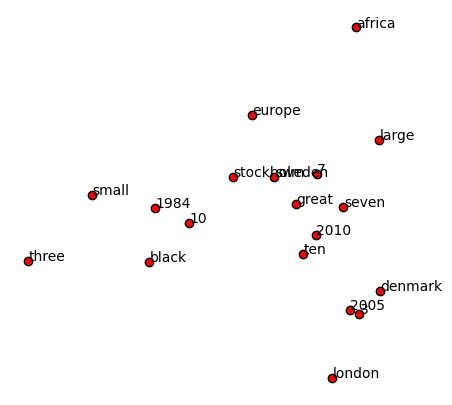

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
def plot_embeddings_pca(emb, voc, words):
    vectors = np.vstack([emb.weight[voc.get_token_id(w)].cpu().detach().numpy() for w in words])
    vectors -= vectors.mean(axis=0)
    twodim = TruncatedSVD(n_components=2).fit_transform(vectors)
    plt.figure(figsize=(5,5))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.02, y, word)
    plt.axis('off')
    plt.show()

plot_embeddings_pca(model.embeddings, vocab_builder, ['sweden', 'denmark', 'europe', 'africa', 'london', 'stockholm', 'large', 'small', 'great', 'black', '3', '7', '10', 'seven', 'three', 'ten', '1984', '2005', '2010'])
